In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os
import pandas as pd
import matplotlib.patches as mpatches

2024-01-29 14:43:12.873406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 14:43:12.873442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 14:43:12.874376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 14:43:12.879987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 14:43:13.458345: W tensorflow/compiler/tf2

In [10]:
input_image = 'food5.jpg'

Area Based Segmentaion Quantification

In [3]:
total_area = 100 #cm^2
depth_factor = 1 #cm

In [11]:

# Extract the tar.gz model
model_filename = 'seefood_segmenter_mobile_food_segmenter_V1_1.tar.gz'
extracted_folder_path = 'extracted_model'

if not os.path.exists(extracted_folder_path):
    with tarfile.open(model_filename, 'r:gz') as tar:
        tar.extractall(path=extracted_folder_path)

# 1. Load the image
# image_path = 'test.jpg'
image_path = input_image
image = tf.image.decode_image(tf.io.read_file(image_path))
image = tf.image.resize(image, [513, 513])
image = image / 255.0  # Normalize to [0, 1]

# Check if the image is 3-channel RGB
if image.shape[-1] != 3:
    print("Make sure your image is RGB.")

# Expand dimensions for batch
image_batch = tf.expand_dims(image, 0)

# 2. Load the local model with specified output keys
m = hub.KerasLayer(extracted_folder_path, signature_outputs_as_dict=True)

# 3. Use the model
results = m(image_batch)

segmentation_probs = results['food_group_segmenter:semantic_probabilities'][0]
segmentation_mask = results['food_group_segmenter:semantic_predictions'][0]
class_label = {}


labels_csv_path = os.path.join('labelmap.csv')
labels_df = pd.read_csv(labels_csv_path)
# Assuming the CSV has 'id' and 'name' columns
class_names = labels_df.sort_values('id')['name'].tolist()


# Calculate the average probability for each class
avg_probabilities = np.mean(segmentation_probs, axis=(0, 1))

#convert legend_labels to dictionary as class names and avg_probabilities as values
area_dict = dict(zip(class_names, avg_probabilities))
# legend_labels = [f"{name} ({avg_prob:.2%})" for name, avg_prob in zip(class_names, avg_probabilities)]
print(area_dict)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


{'background': 0.0830791, 'vegetables | leafy_greens': 0.08909876, 'vegetables | stem_vegetables': 0.0024410556, 'vegetables | non-starchy_roots': 0.10820323, 'vegetables | other': 0.056856483, 'fruits': 0.027034555, 'protein | meat': 0.14051957, 'protein | poultry': 0.002023512, 'protein | seafood': 0.014916539, 'protein | eggs': 0.00039915895, 'protein | beans/nuts': 0.0034857085, 'starches/grains | baked_goods': 0.002983429, 'starches/grains | rice/grains/cereals': 0.00019989579, 'starches/grains | noodles/pasta': 0.00040345732, 'starches/grains | starchy_vegetables': 0.14771767, 'starches/grains | other': 0.0008235848, 'soups/stews': 0.012894725, 'herbs/spices': 0.062027868, 'dairy': 0.0069004227, 'snacks': 0.003688594, 'sweets/desserts': 0.00016524913, 'beverages': 0.0007703512, 'fats/oils/sauces': 0.040083222, 'food_containers': 0.17792894, 'dining_tools': 0.004814345, 'other_food': 0.010311252}


In [16]:
import pandas as pd

# Read the nutrient information from the CSV file
nutrient_data = pd.read_csv('sample.csv')
# Convert the DataFrame to a dictionary with category as key and nutrients as sub-dictionary
nutrient_info = {row['Category'].lower().replace(' ', '_'): row.to_dict() for index, row in nutrient_data.iterrows()}

# Example segmentation dictionary (as provided in the prompt)
segmentation_areas = area_dict

# Given variables for total area and depth (in cm and cm2)
total_area_cm2 = 625  # replace with the actual total area in cm2
depth_cm = 5  # replace with the actual depth in cm

# Function to convert the segmentation area to mass using density and depth
def area_to_mass(area_percentage, density, depth, total_area):
    volume_cm3 = area_percentage * total_area * depth
    return volume_cm3 * density  # mass in grams

# Initialize a dictionary to hold total nutrient values
total_nutrients = {
    'Energy (kcal)': 0,
    'Protein (g)': 0,
    'Fat (g)': 0,
    'Iron (mg)': 0,
    'Zinc (mg)': 0,
    'Calcium (mg)': 0,
}

# Iterate over the segmentation areas and calculate the total nutrients
for food_category, area_percentage in segmentation_areas.items():
    # Normalize the category key to match the nutrient info keys
    category_key = food_category.replace(' | ', '_').replace(' ', '_').lower()
    if category_key in nutrient_info:
        # Calculate the mass of the food category
        density = nutrient_info[category_key].get('Density (g/cm³)', 1)  # default density to 1 if not available
        mass_g = area_to_mass(area_percentage, density, depth_cm, total_area_cm2)
        # Update the total nutrient values by adding the nutrient content of the current food category
        for nutrient in total_nutrients.keys():
            nutrient_value = nutrient_info[category_key].get(nutrient, 0)
            total_nutrients[nutrient] += nutrient_value * mass_g

# Output the total nutrients with values formatted to 2 decimal places
for nutrient, value in total_nutrients.items():
    print(f"{nutrient}: {round(value, 2)}")


Energy (kcal): 277.78
Protein (g): 10.07
Fat (g): 5.93
Iron (mg): 0.48
Zinc (mg): 0.17
Calcium (mg): 1931.63


Step1: Remove Plates and Stuff

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


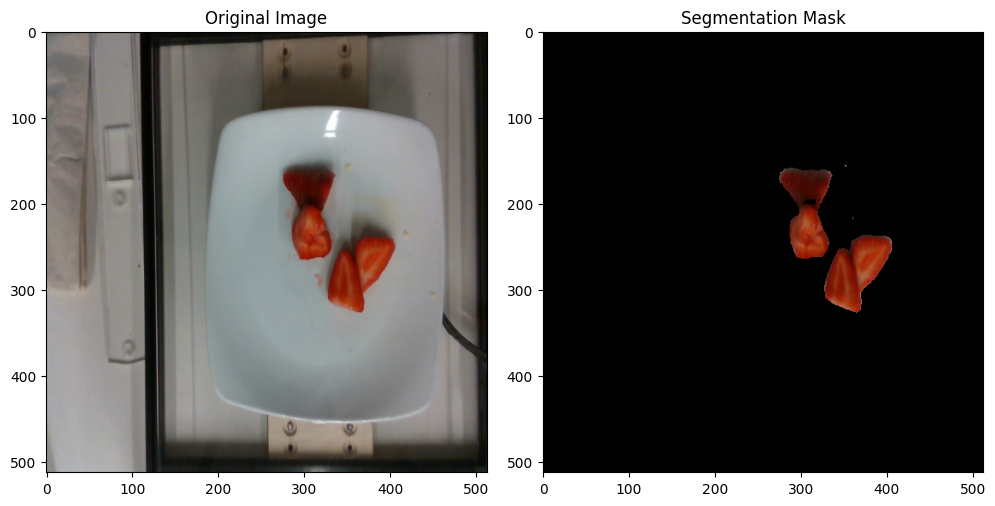

In [23]:


# Extract the tar.gz model
model_filename = 'seefood_segmenter_mobile_food_segmenter_V1_1.tar.gz'
extracted_folder_path = 'extracted_model'

if not os.path.exists(extracted_folder_path):
    with tarfile.open(model_filename, 'r:gz') as tar:
        tar.extractall(path=extracted_folder_path)

# 1. Load the image
# image_path = 'test.jpg'
image_path = input_image
image = tf.image.decode_image(tf.io.read_file(image_path))
image = tf.image.resize(image, [513, 513])
image = image / 255.0  # Normalize to [0, 1]

# Check if the image is 3-channel RGB
if image.shape[-1] != 3:
    print("Make sure your image is RGB.")

# Expand dimensions for batch
image_batch = tf.expand_dims(image, 0)

# 2. Load the local model with specified output keys
m = hub.KerasLayer(extracted_folder_path, signature_outputs_as_dict=True)

# 3. Use the model
results = m(image_batch)

segmentation_probs = results['food_group_segmenter:semantic_probabilities'][0]
segmentation_mask = results['food_group_segmenter:semantic_predictions'][0]

# Define the label classes to remove (adjust as needed)
classes_to_remove = [0, 23, 24]  # Example: Remove classes 2, 4, and 6

# Create a mask to remove the specified classes
mask_to_remove = np.isin(segmentation_mask, classes_to_remove)

# Apply the mask to remove the corresponding regions from the original image
image_without_classes = image * (1 - mask_to_remove[..., tf.newaxis])  # Set to black (or any desired background color)

# Save the modified image without specified classes
output_image_path = 'modified_image.png'  # Specify the desired output path and filename
tf.keras.preprocessing.image.save_img(output_image_path, image_without_classes.numpy())  # Save the modified image


# 4. Display the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(image_without_classes.numpy())
plt.title('Segmentation Mask')

# plt.subplot(1, 3, 3)
# # Overlay the segmentation mask on the original image
# class_id = 5
# overlay = np.where(segmentation_mask == class_id, 1, 0)
# plt.imshow(image)
# plt.imshow(overlay, alpha=0.5)
# plt.title(f'Overlay (for class {class_id})')

plt.tight_layout()
plt.show()




Monocular Depth Estimation

In [24]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


/home/ashikh/.local/lib/python3.10/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


[[1387.2527  1388.468   1391.6671  ... 1085.6766   966.4196   798.05475]
 [1361.4738  1380.1042  1395.0577  ... 1064.8334  1021.2995   966.12836]
 [1364.6718  1382.0745  1395.1268  ... 1055.0182  1063.0875  1081.5249 ]
 ...
 [2237.5652  2236.6284  2233.903   ... 2099.903   2094.947   2087.6238 ]
 [2235.5344  2235.616   2234.473   ... 2097.9685  2090.198   2078.6729 ]
 [2228.243   2233.3838  2233.2017  ... 2095.519   2083.536   2072.1785 ]]


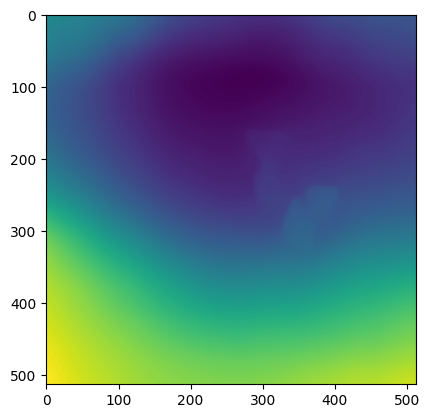

In [25]:
from PIL import Image
import numpy as np
import requests
import torch
import sys

from transformers import DPTForDepthEstimation, DPTFeatureExtractor

torch.device('cpu')

model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=False)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")


image = Image.open('modified_image.png')


# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
print(output)
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
# depth.show()

depth.save("MT_Depth_UnMasked.png")
plt.imshow(depth)

Remove The Depth Mask with the original Mask

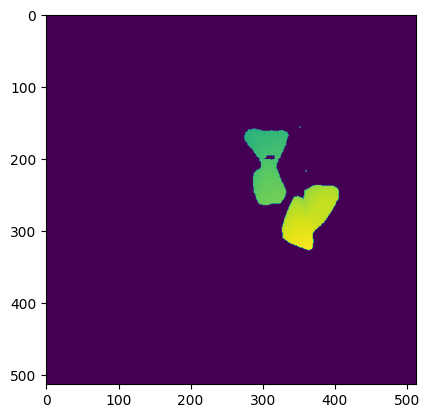

In [26]:

# Assuming you have loaded the new image as 'new_image' (similar to loading the original image)
# 1. Load the image
# image_path = 'test.jpg'
image_path = 'MT_Depth_UnMasked.png'
image = tf.image.decode_image(tf.io.read_file(image_path))
image = tf.image.resize(image, [513, 513])
new_image = image / 255.0  # Normalize to [0, 1]


# 1. Apply the mask to the new image to remove the background
new_image_without_background = new_image * (1 - mask_to_remove[..., tf.newaxis])  # Set to black (or any desired background color)

# 2. Save the new image without the background
output_new_image_path = 'MT_Depth_Masked.png'  # Specify the output path and filename
tf.keras.preprocessing.image.save_img(output_new_image_path, new_image_without_background.numpy())  # Save the new image without the background

plt.imshow(new_image_without_background)


Skip single core Quantification

In [27]:
# import numpy as np
# from pyntcloud import PyntCloud
# import pandas as pd
# from scipy.spatial import Delaunay
# from stl import mesh

# depthim = new_image_without_background

# # Take only the first channel of the depth image
# depthim = depthim[:, :, 0]

# # Create a point cloud from the depth image
# points_data = np.dstack(np.mgrid[0:depthim.shape[0], 0:depthim.shape[1]]) 
# points_data = np.dstack((points_data, depthim))
# points_data = points_data.reshape(-1, 3)

# cloud = PyntCloud(pd.DataFrame(points_data, columns=['x', 'y', 'z']))

# # Create a mesh from the triangulation
# mesh_vertices = cloud.points.values
# faces = Delaunay(mesh_vertices).simplices

# # Correct the orientation of the triangles
# for i, f in enumerate(faces):
#     v0 = mesh_vertices[f[0], :]
#     v1 = mesh_vertices[f[1], :]
#     v2 = mesh_vertices[f[2], :]
#     volume = np.dot(v0, np.cross(v1, v2))
#     if volume < 0:  # If the volume is negative
#         faces[i] = f[::-1]  # Reverse the order of the vertices

# # Create the mesh with corrected faces
# mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
# for i, f in enumerate(faces):
#     for j in range(3):
#         mesh.vectors[i][j] = mesh_vertices[f[j], :]

# # Calculate the volume of the mesh
# volume = mesh.get_mass_properties()[0]

# # Print the estimated volume
# print(f"Estimated volume of food: {volume} cubic units")

-  Multiprocess    

In [28]:
# from pyntcloud import PyntCloud
# from scipy.spatial import Delaunay
# from stl import mesh
# import concurrent.futures

# depthim = new_image_without_background

# # Take only the first channel of the depth image
# depthim = depthim[:, :, 0]
# print(depthim.shape)

# # Create a point cloud from the depth image
# points_data = np.dstack(np.mgrid[0:depthim.shape[0], 0:depthim.shape[1]]) 
# points_data = np.dstack((points_data, depthim))
# points_data = points_data.reshape(-1, 3)

# print(points_data.shape)

# cloud = PyntCloud(pd.DataFrame(points_data, columns=['x', 'y', 'z']))

# print(cloud.points.values.shape)

# # Create a mesh from the triangulation
# mesh_vertices = cloud.points.values
# faces = Delaunay(mesh_vertices).simplices

# # Correct the orientation of the triangles
# def correct_orientation(i):
#     f = faces[i]
#     v0 = mesh_vertices[f[0], :]
#     v1 = mesh_vertices[f[1], :]
#     v2 = mesh_vertices[f[2], :]
#     volume = np.dot(v0, np.cross(v1, v2))
#     if volume < 0:  # If the volume is negative
#         return f[::-1]  # Reverse the order of the vertices
#         print("Reversed")
#     else:
#         print("Not Reversed")
#         return f

# with concurrent.futures.ProcessPoolExecutor() as executor:
#     faces = list(executor.map(correct_orientation, range(len(faces))))

# # Create the mesh with corrected faces
# mesh = mesh.Mesh(np.zeros(len(faces), dtype=mesh.Mesh.dtype))
# for i, f in enumerate(faces):
#     for j in range(3):
#         mesh.vectors[i][j] = mesh_vertices[f[j], :]

# # Calculate the volume of the mesh
# volume = mesh.get_mass_properties()[0]

# # Print the estimated volume
# print(f"Estimated volume of food: {volume} cubic units")

In [29]:
# import open3d as o3d
# import numpy as np
# import trimesh

# depthim = new_image_without_background

# # Create a point cloud from the depth image
# points_data = np.dstack(np.mgrid[0:depthim.shape[0], 0:depthim.shape[1]]) 

# # Ensure depthim is a 3-dimensional array
# if len(depthim.shape) == 2:
#     depthim = np.expand_dims(depthim, axis=2)

# points_data = np.append(points_data, depthim, axis=2)
# points_data = points_data.reshape(-1, 3)

# # Create a point cloud
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points_data)

# # Estimate normals
# pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# # Create the triangle mesh
# mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8)

# # Convert Open3D mesh to trimesh mesh
# vertices = np.asarray(mesh.vertices)
# faces = np.asarray(mesh.triangles)
# trimesh_mesh = trimesh.Trimesh(vertices, faces)

# # Compute volume
# volume = trimesh_mesh.volume

# print(f"Estimated volume of food: {volume} cubic units")

In [30]:
import open3d as o3d
import numpy as np
import trimesh

depthim = new_image_without_background

# Create a point cloud from the depth image
points_data = np.dstack(np.mgrid[0:depthim.shape[0], 0:depthim.shape[1]]) 

# Ensure depthim is a 3-dimensional array
if len(depthim.shape) == 2:
    depthim = np.expand_dims(depthim, axis=2)

points_data = np.append(points_data, depthim, axis=2)
points_data = points_data.reshape(-1, 3)

# Create a point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_data)

# Estimate normals
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Create the triangle mesh
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8)

# Convert Open3D mesh to trimesh mesh
vertices = np.asarray(mesh.vertices)
faces = np.asarray(mesh.triangles)
trimesh_mesh = trimesh.Trimesh(vertices, faces)

# Fix the normals
trimesh_mesh.fix_normals()

# Compute volume
volume = trimesh_mesh.volume

print(f"Estimated volume of food: {volume} cubic units")

Estimated volume of food: 1179980.0778388982 cubic units


In [31]:
# import numpy as np
# from pyntcloud import PyntCloud
# import cv2
# import pandas as pd
# from scipy.spatial import Delaunay
# from stl import mesh

# depthim = new_image_without_background

# # Create a point cloud from the depth image
# points_data = np.dstack(np.mgrid[0:depthim.shape[0], 0:depthim.shape[1]]) 
# points_data = np.append(points_data, np.expand_dims(depthim, axis=2), axis=2)
# points_data = points_data.reshape(-1, 3)

# cloud = PyntCloud(pd.DataFrame(points_data, columns=['x', 'y', 'z']))

# # Create a mesh from the triangulation
# mesh_vertices = cloud.points.values
# faces = Delaunay(mesh_vertices).simplices

# # Correct the orientation of the triangles
# for i, f in enumerate(faces):
#     v0 = mesh_vertices[f[0], :]
#     v1 = mesh_vertices[f[1], :]
#     v2 = mesh_vertices[f[2], :]
#     volume = np.dot(v0, np.cross(v1, v2))
#     if volume < 0:  # If the volume is negative
#         faces[i] = f[::-1]  # Reverse the order of the vertices

# # Create the mesh with corrected faces
# mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
# for i, f in enumerate(faces):
#     for j in range(3):
#         mesh.vectors[i][j] = mesh_vertices[f[j], :]

# # Calculate the volume of the mesh
# volume = mesh.get_mass_properties()[0]

# # Print the estimated volume
# print(f"Estimated volume of food: {volume} cubic units")

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [ ]:
# import numpy as np
# from pyntcloud import PyntCloud
# import pandas as pd
# from scipy.spatial import Delaunay
# from stl import mesh
# import concurrent.futures
# from tqdm import tqdm

# depthim = new_image_without_background

# # Take only the first channel of the depth image
# depthim = depthim[:, :, 0]

# # Create a point cloud from the depth image
# points_data = np.dstack(np.mgrid[0:depthim.shape[0], 0:depthim.shape[1]]) 
# points_data = np.dstack((points_data, depthim))
# points_data = points_data.reshape(-1, 3)

# cloud = PyntCloud(pd.DataFrame(points_data, columns=['x', 'y', 'z']))

# # Create a mesh from the triangulation
# mesh_vertices = cloud.points.values
# faces = Delaunay(mesh_vertices).simplices

# # Correct the orientation of the triangles
# def correct_orientation(i):
#     f = faces[i]
#     v0 = mesh_vertices[f[0], :]
#     v1 = mesh_vertices[f[1], :]
#     v2 = mesh_vertices[f[2], :]
#     volume = np.dot(v0, np.cross(v1, v2))
#     if volume < 0:  # If the volume is negative
#         return f[::-1]  # Reverse the order of the vertices
#     else:
#         return f

# with concurrent.futures.ProcessPoolExecutor() as executor:
#     faces = list(tqdm(executor.map(correct_orientation, range(len(faces))), total=len(faces)))

# # Create the mesh with corrected faces
# mesh = mesh.Mesh(np.zeros(len(faces), dtype=mesh.Mesh.dtype))
# for i, f in enumerate(faces):
#     for j in range(3):
#         mesh.vectors[i][j] = mesh_vertices[f[j], :]

# # Calculate the volume of the mesh
# volume = mesh.get_mass_properties()[0]

# # Print the estimated volume
# print(f"Estimated volume of food: {volume} cubic units")

Point Cloud Visualization

In [ ]:
import trimesh

# Assuming you have a trimesh.Trimesh object 'trimesh_mesh'

# Create a scene
scene = trimesh.Scene(trimesh_mesh)

# Display the scene
scene.show()

NameError: name 'point_cloud' is not defined

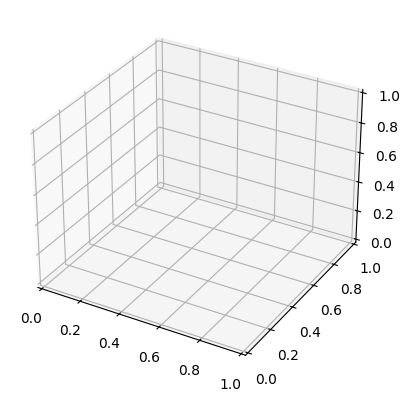

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Assuming you have a point cloud in the variable 'point_cloud'
# # It should be a 2D NumPy array with columns for x, y, and z coordinates

# # Create a 3D scatter plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)  # 's' controls point size

# # Set axis labels (customize as needed)
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Y Axis')
# ax.set_zlabel('Z Axis')

# # Show the plot
# plt.show()


NameError: name 'point_cloud' is not defined

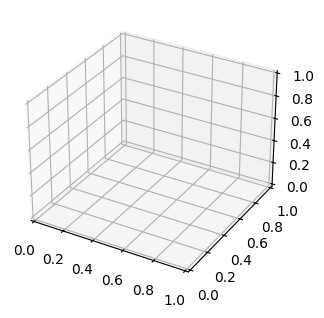

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Assuming you have a point cloud in the variable 'point_cloud'
# # It should be a 2D NumPy array with columns for x, y, and z coordinates

# # Create a figure with four subplots
# fig = plt.figure(figsize=(12, 8))

# # Create the first subplot (top-left)
# ax1 = fig.add_subplot(221, projection='3d')
# ax1.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
# ax1.set_title('View 1')

# # Create the second subplot (top-right)
# ax2 = fig.add_subplot(222, projection='3d')
# ax2.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
# ax2.view_init(elev=0, azim=90)  # Adjust the view angle (elevation and azimuth)
# ax2.set_title('View 2')

# # Create the third subplot (bottom-left)
# ax3 = fig.add_subplot(223, projection='3d')
# ax3.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
# ax3.view_init(elev=0, azim=180)  # Adjust the view angle
# ax3.set_title('View 3')

# # Create the fourth subplot (bottom-right)
# ax4 = fig.add_subplot(224, projection='3d')
# ax4.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
# ax4.view_init(elev=0, azim=270)  # Adjust the view angle
# ax4.set_title('View 4')

# # Set common labels for the entire figure
# fig.text(0.5, 0.04, 'X Axis', ha='center')
# fig.text(0.04, 0.5, 'Y Axis', va='center', rotation='vertical')
# fig.text(0.92, 0.5, 'Z Axis', va='center', rotation='vertical')

# # Adjust spacing between subplots
# plt.tight_layout()

# # Show the plot
# plt.show()
